# Project 4: Poisonous Mushrooms

**Solution**

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

## Grading
---
- Make sure to answer every part in every question.
 - There are 6 equally weighted questions.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Question 1:PCA and fraction of total variance
---

1. Do a principal components analysis on the data.
1. Print what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].
1. Show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
1. You only need to call PCA.fit once.

Notes:
* The pandas DataFrame [cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) function may be helpful.
* You can use `PCA` to produce a PCA analysis.

Explained variance for 1 Components: 0.16404331279334272
Explained variance for 2 Components: 0.2972781014878153
Explained variance for 3 Components: 0.39901266670928076
Explained variance for 4 Components: 0.4696462310591405
Explained variance for 5 Components: 0.5083126945661669
Explained variance for 10 Components: 0.6522148325627521
Explained variance for 20 Components: 0.8089677659561177
Explained variance for 30 Components: 0.8985493780560347
Explained variance for 40 Components: 0.9509282406029382
Explained variance for 50 Components: 0.9821028525657515


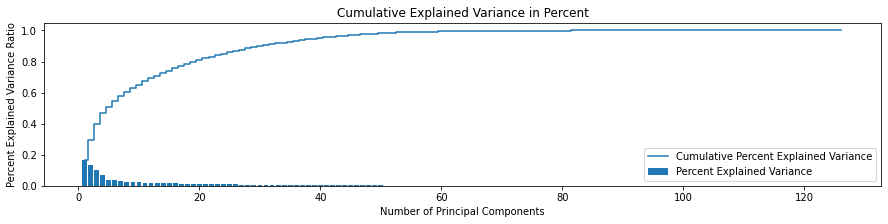

In [5]:
def P1():
  # Fit PCA to training data.
  pca = PCA()
  transformed = pca.fit_transform(train_data)

  # Ratio of variance explained by each component.
  percent_variance = pca.explained_variance_ratio_

  # Print cumulative explained variance over multiple components.
  for num in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    print(f"Explained variance for {num} Components: {np.sum(pca.explained_variance_ratio_[:num])}")

  # Plot cumlative explained variance over components.
  dimensions = range(1,127)
  plt.figure(figsize=(15, 3))
  plt.bar(dimensions, percent_variance, label='Percent Explained Variance')
  plt.step(dimensions, np.cumsum(percent_variance), where='mid', label='Cumulative Percent Explained Variance')
  plt.legend()
  plt.title("Cumulative Explained Variance in Percent")
  plt.ylabel('Percent Explained Variance Ratio')
  plt.xlabel('Number of Principal Components')
  plt.show()

P1()

### Question 2: PCA for visualization

PCA can be very useful for visualizing data. 
1. Project the training data down to 2 dimensions and show as a square scatterplot.
  - Show poisonous examples (labeled 1) in red and non-poisonous examples in green (labeled 0)
  - Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.
* Be sure to add a title, axis labels and a legend to your graph.

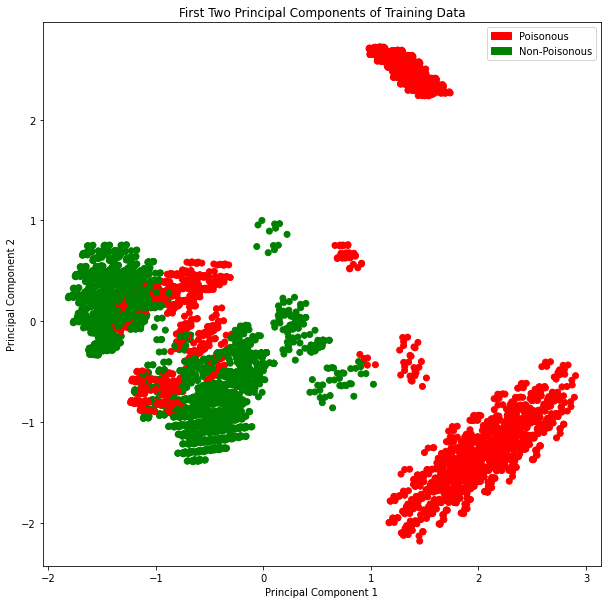

In [6]:
def Q2():  
  # Fit PCA to training data. 
  pca = PCA(n_components=2)
  transformed = pca.fit_transform(train_data)

  # Plot first two pricipal components.
  plt.figure(figsize=(10, 10))
  plt.scatter([i[0] for i in transformed], [i[1] for i in transformed], 
              c=['red' if label == 1 else 'green' for label in train_labels])
  plt.title("First Two Principal Components of Training Data")
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.legend(handles=[mpatches.Patch(color='red', label='Poisonous'), 
                      mpatches.Patch(color='green', label='Non-Poisonous')])
  plt.show()
Q2()

### Question 3: Visualizing GMMs
---

1. Fit a k-means cluster model with 6 clusters over the 2d projected data. 
  - As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  
  - For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

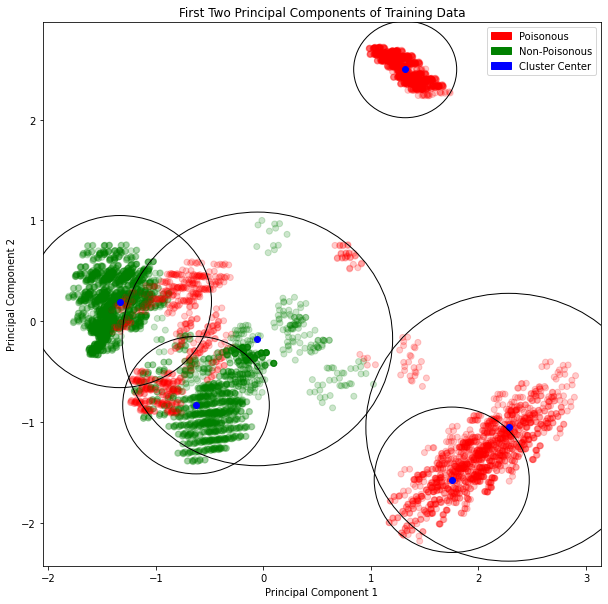

In [7]:
def Q3():   
  # Fit PCA to training data. 
  pca = PCA(n_components=2)
  transformed = pca.fit_transform(train_data)
  
  # Fit KMeans classifier to 2D projected data.
  km = KMeans(n_clusters=6).fit(transformed, train_labels)
  cluster_centers = km.cluster_centers_

  # Calculate distances from each cluster center to find radius of circle around cluster center.
  max_radii = []
  for index, center in enumerate(cluster_centers):
    # Get observations that belong to cluster center
    observations = transformed[np.argwhere(km.labels_ == index)]
    radii = []
    for observation in observations:
      radii.append(np.linalg.norm(center - observation[0]))
    max_radii.append(max(radii))

  # Plot first two pricipal components.
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.scatter([i[0] for i in transformed], [i[1] for i in transformed], 
              c=['red' if label == 1 else 'green' for label in train_labels], alpha=0.2)
  ax.scatter([i[0] for i in cluster_centers], [i[1] for i in cluster_centers], c='blue')
  for cluster_center, radius in zip(cluster_centers, max_radii):
    ax.add_artist(plt.Circle(cluster_center, radius, fill=False))
  ax.set_title("First Two Principal Components of Training Data")
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.legend(handles=[mpatches.Patch(color='red', label='Poisonous'), 
                      mpatches.Patch(color='green', label='Non-Poisonous'),
                      mpatches.Patch(color='blue', label='Cluster Center')])
  plt.show()

Q3()

### Question 4: Understanding GMMs with Density Plots
---

1. Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. 
  - Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  
  - Show a 4x4 grid of square-shaped plots of the estimated density contours. 
    - Each row showing a different number of mixture components. 
    - Each column showing a different convariance matrix type.  
1. Be sure to add a title for each plot in the grid to indicate what parameters were used.
1. How are the covariance types 'tied' and 'full' different? How do you see it in the plots?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

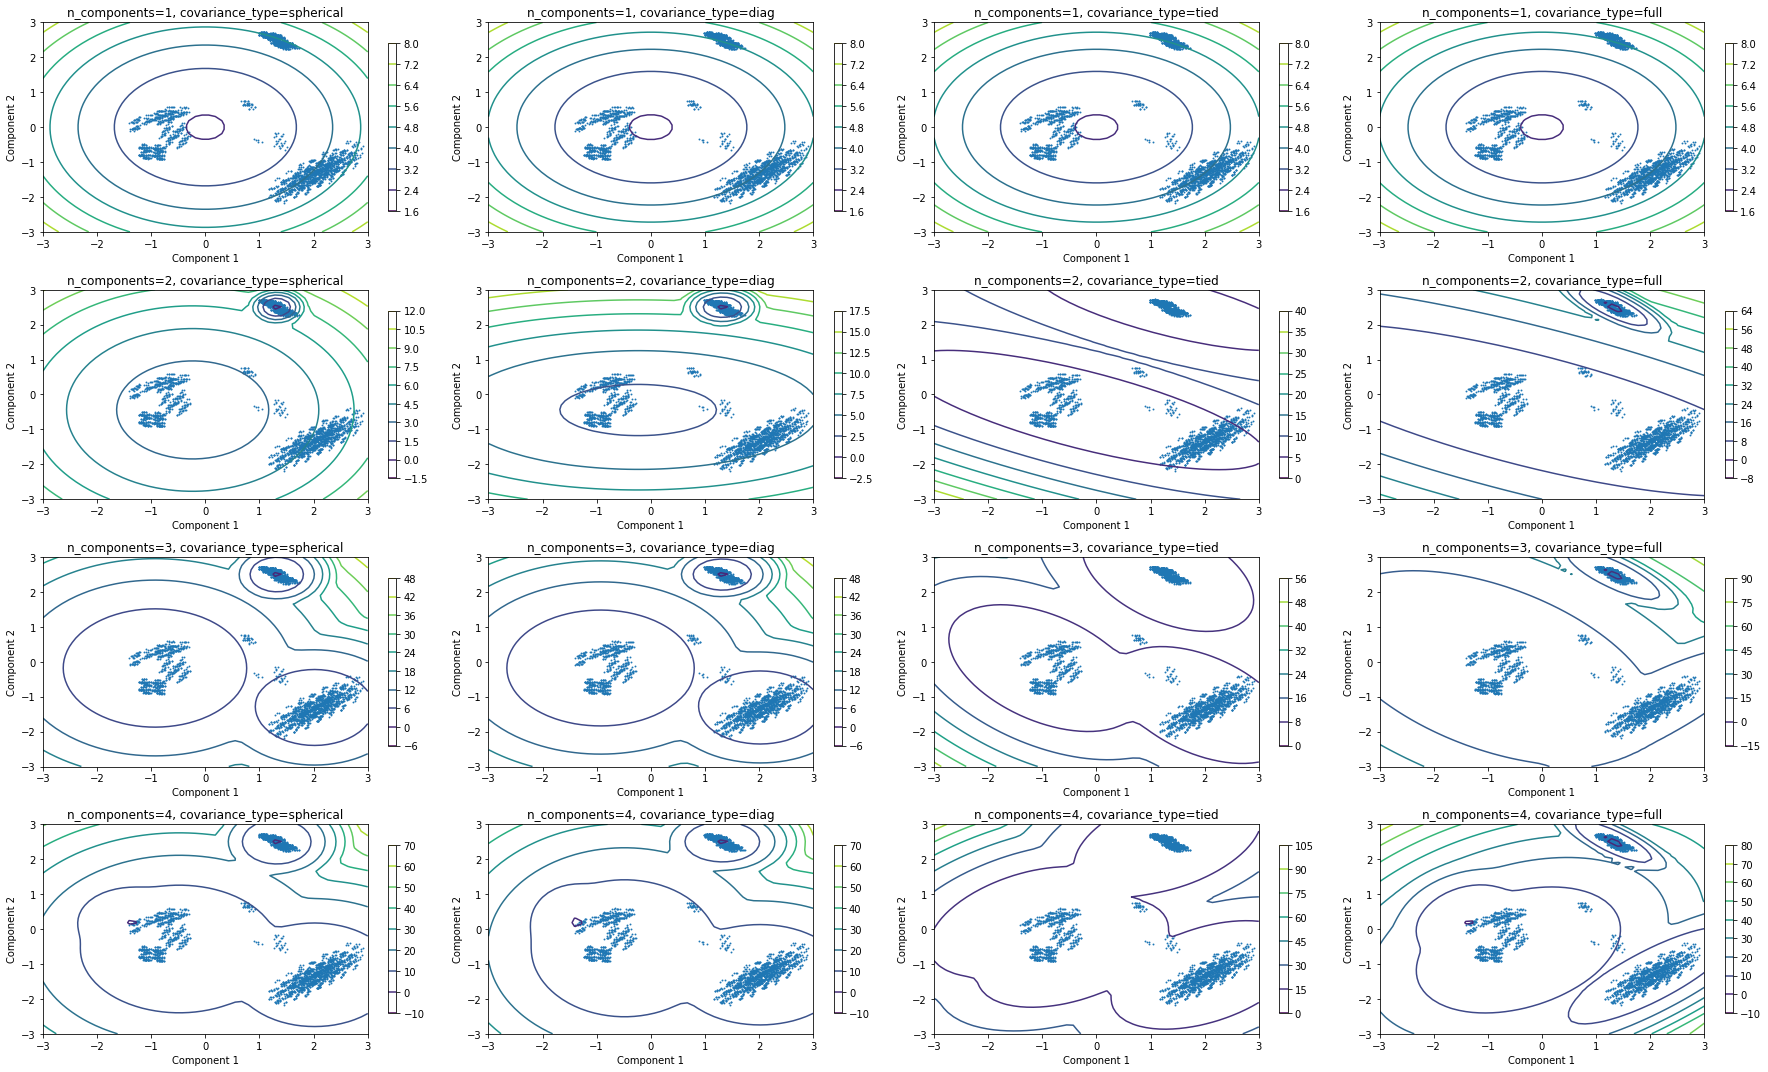

In [8]:
def Q4():
  # Fit PCA to training data. 
  pca = PCA(n_components=2)
  transformed = pca.fit_transform(train_data)
  # Get observations where label is 'Poisonous'.
  transformed_poisonous = transformed[np.where(train_labels == 1)]

  # Create 4x4 plot.
  fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(25,15))

  # Iterate over components 1-4 and over different covariance matrix types
  for i, component in enumerate(range(1,5)):
    for j, covariance_type in enumerate(['spherical', 'diag', 'tied', 'full']):
      # Fit GM model.
      gmm = GaussianMixture(n_components=component, covariance_type=covariance_type, random_state=12345)
      gmm.fit(transformed)
      
      # Create mesh grid to build contour plot over
      x = np.linspace(-3.0, 3.0)
      y = np.linspace(-3.0, 3.0)
      X, Y = np.meshgrid(x, y)
      XX = np.array([X.ravel(), Y.ravel()]).T
      Z = -gmm.score_samples(XX)
      Z = Z.reshape(X.shape)
      # Display predicted scores by the model as a contour plot
      CS = axes[i][j].contour(X, Y, Z)
      CB = plt.colorbar(CS, ax=axes[i][j], shrink=0.8, extend="both")
      axes[i][j].scatter(transformed_poisonous[:, 0], transformed_poisonous[:, 1], 0.8)
      axes[i][j].axis("tight")
      axes[i][j].set_title(f"n_components={component}, covariance_type={covariance_type}")
      axes[i][j].set_xlabel("Component 1")
      axes[i][j].set_ylabel("Component 2")
  
  plt.tight_layout()
  plt.show()

Q4()

Answer:

When we take a look at the models that have been fitted with a tied covariance matrix, we can see that all the components have the same shape, although they may take any size. Comparing this to the models that have been fitted with the full covariance matrix, we can see that the components are independent of each other and can take any shape/size.

### Question 5: Using Unsupervised models for classification...?
---

1. Fit two Gaussian mixture models:
  - On your 2d projected training data. 
    - Form a subset of all the poisonous examples and fit one GMM (gmm_poison).
    - Form a subset of all the non-poisonous examples and fit another GMM (gmm_nonpoison).
  - Use 4 mixture components and full convariance for each model.  
1. Use the above trained GMMs to classify examples in your test set:
   - For each example in the test set
     - Measure how likely it is to have been "generated" by gmm_poison and gmm_nonpoison (using score_samples).
     - Predict the more likely label.
  - You can use score_samples.
  - You can do this without a for loop which will be more efficient.
1. What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [9]:
def Q5():  
  # Fit PCA to training data. 
  pca = PCA(n_components=2)
  transformed_train = pca.fit_transform(train_data)

  # Transform test data.
  transformed_test = pca.transform(test_data)

  # Get observations where label is 'Poisonous' and 'Non-Poisonous'.
  transformed_poisonous = transformed_train[np.where(train_labels == 1)]
  transformed_nonpoisonous = transformed_train[np.where(train_labels == 0)]

  # Fit GM model for each subset of data.
  gmm_poison = GaussianMixture(n_components=4, covariance_type='full', random_state=12345).fit(transformed_poisonous)
  gmm_nonpoison = GaussianMixture(n_components=4, covariance_type='full', random_state=12345).fit(transformed_nonpoisonous)

  # Compute log likelihood of for each testing sample.
  poison_proba = gmm_poison.score_samples(transformed_test)
  nonpoison_proba = gmm_nonpoison.score_samples(transformed_test)

  # Find GMM that has bigger log likelihood.
  predicted = []
  for poison_prob, nonpoison_prob in zip(poison_proba, nonpoison_proba):
    if poison_prob > nonpoison_prob:
      predicted.append(1)
    else:
      predicted.append(0)

  # Calculate prediction accuracy.
  print(f"Prediction Accuracy: {metrics.accuracy_score(test_labels, predicted)}")


Q5()

Prediction Accuracy: 0.9501779359430605


### Question 6: Understanding the GMM parameters
---

1. Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.
1. Print the best configuration and accuracy.
1. Plot a scatter plot of accuracy vs #params.
1. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.



Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* [This spreadsheet](https://docs.google.com/spreadsheets/d/1LTEOU7q_Tgs4bX_3o2ePjDQrTRToZoc1J5XLlaRbmI0/edit?usp=sharing) should help (accessible from your google @berkeley.edu account)

* Spherical - Each GMM component has a mean per dimension, and one variance. 
* Diag - Each GMM component has a mean per dimension and a variance for each dimension.
* full - Each GMM component has a mean per dimension and a "full" covariance matrix. Only the covariance matrix is symmetric, so its $[i,j]$ entry would equal to its $[j,i]$ entry.
* tied - Finally, tied has all components share a single covariance matrix. So each GMM component has a mean per dimension but they all share the same 'full' covariance matrix.


  Model with Highest Accuracy=0.9359430604982206 
  Paramters: 
  PCA Components=2 
  GMM Components=3
  Covariance Type=diag

  


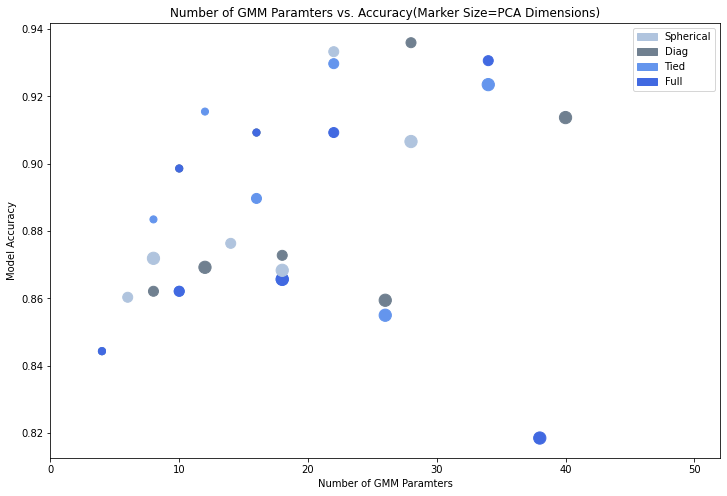

In [10]:
from numpy.lib.function_base import cov
from matplotlib.lines import Line2D

def get_num_gmm_params(n_pca, n_gmm, cov_type, n_classes):
  """
  Method to calculate the number of paramters in the Gaussian Mixture Model.
  """
  if cov_type == 'full':
    return int(((n_gmm - 1) + n_pca*n_gmm + n_pca * (n_pca + 1)/ 2 * n_gmm) * n_classes)				
  elif cov_type == 'diag':
    return int(((n_gmm - 1) + n_pca*n_gmm + n_pca * n_gmm) * n_classes)
  elif cov_type == 'spherical':
    return int(((n_gmm - 1) +n_pca*n_gmm + n_gmm) * n_classes)
  elif cov_type == 'tied':
    return int(((n_gmm - 1) +n_pca*n_gmm + n_pca * (n_pca + 1)/ 2) * n_classes)
  else:
    raise NotImplementedError


def Q6():
  # Capture configurated parameters and accuracy for each model.
  config = []
  accuracy = []

  for n_pca in [1, 2, 3]: # Number of PCA components.
    for n_gmm in [1, 2, 3]: # Number of GMM components.
      for cov_type in ['spherical', 'diag', 'tied', 'full'] : # Covariance types for GMM.
        # Capture model config params.
        config.append({
          'n_pca': n_pca,
          'n_gmm': n_gmm,
          'covariance_type': cov_type  
        })
        # Perform PCA with selected number of components.
        pca = PCA(n_components=n_pca)
        transformed_train = pca.fit_transform(train_data)
        # Transform test data.
        transformed_test = pca.transform(test_data)
        # Get observations where label is 'Poisonous' and 'Non-Poisonous'.
        transformed_poisonous = transformed_train[np.where(train_labels == 1)]
        transformed_nonpoisonous = transformed_train[np.where(train_labels == 0)]
        # Fit GM model for each subset of data.
        gmm_poison = GaussianMixture(n_components=n_gmm, covariance_type=cov_type, random_state=12345).fit(transformed_poisonous)
        gmm_nonpoison = GaussianMixture(n_components=n_gmm, covariance_type=cov_type, random_state=12345).fit(transformed_nonpoisonous)

        # Compute log likelihood of for each testing sample.
        poison_proba = gmm_poison.score_samples(transformed_test)
        nonpoison_proba = gmm_nonpoison.score_samples(transformed_test)

        # Find GMM that has bigger log likelihood.
        predicted = []
        for poison_prob, nonpoison_prob in zip(poison_proba, nonpoison_proba):
          if poison_prob > nonpoison_prob:
            predicted.append(1)
          else:
            predicted.append(0)
        # Capture model accuracy.
        accuracy.append(metrics.accuracy_score(test_labels, predicted))

  # Find model with best accuracy.
  max_accuracy_idx = np.argmax(accuracy)
  print(f"""
  Model with Highest Accuracy={accuracy[max_accuracy_idx]} 
  Paramters: 
  PCA Components={config[max_accuracy_idx]['n_pca']} 
  GMM Components={config[max_accuracy_idx]['n_gmm']}
  Covariance Type={config[max_accuracy_idx]['covariance_type']}\n
  """)

  # Find number of paramters for each model and save covariance type/PCA dimensions for plotting
  num_paramters = []
  cov_types = []
  pca_dims = []
  for model in config:
    num_paramters.append(
        get_num_gmm_params(model['n_pca'], model['n_gmm'], model['covariance_type'], 2)
    )
    pca_dims.append(model['n_pca']*50) # Scale by 50 for plotting.
    # Add colors to array based on covariance type for plotting.
    if model['covariance_type'] == 'spherical':
      cov_types.append('lightsteelblue')
    elif model['covariance_type'] == 'diag':
      cov_types.append('slategrey')
    elif model['covariance_type'] == 'tied':
      cov_types.append('cornflowerblue')
    elif model['covariance_type'] == 'full':
      cov_types.append('royalblue')

  # Plot parameters vs. accuracy.
  fig, ax = plt.subplots(figsize=(12,8))
  ax.scatter(num_paramters, accuracy, s=pca_dims, c=cov_types)
  ax.set_title("Number of GMM Paramters vs. Accuracy(Marker Size=PCA Dimensions)")
  ax.set_xlabel("Number of GMM Paramters")
  ax.set_ylabel("Model Accuracy")
  ax.set_xlim([0, 52])
  ax.legend(handles=[mpatches.Patch(color='lightsteelblue', label='Spherical'), 
                     mpatches.Patch(color='slategrey', label='Diag'),
                     mpatches.Patch(color='cornflowerblue', label='Tied'),
                     mpatches.Patch(color='royalblue', label='Full')])
  plt.show()

Q6()